In [177]:
import sys
import time
import math
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.special import logit
from scipy.stats import norm

import tensorflow as tf
from keras import layers, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.autograd.profiler as profiler

from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, PowerTransformer
from sklearn.metrics import f1_score, log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [178]:
def calculate_metrics(model, data_tensor, labels_tensor, batch_size=1024, num_features=22):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for start_idx in range(0, len(data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(data_tensor))
            inputs = data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = labels_tensor[start_idx:end_idx]

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [179]:
class CustomDataLoader:
    def __init__(self, features, labels, validation_size=0.2, random_state=42, classification=True):        
        if validation_size > 0.0:
            stratify = labels if classification else None
            train_data, val_data, train_labels, val_labels = train_test_split(
                features, labels, test_size=validation_size, stratify=stratify, random_state=random_state
            )
            
            self.val_data_tensor = torch.tensor(val_data).float().to(device)
            
            if classification:
                self.val_labels_tensor = torch.tensor(val_labels).long().to(device)
            else:
                self.val_labels_tensor = torch.tensor(val_labels).float().to(device)
        else:
            train_data, train_labels = features, labels
            self.val_data_tensor, self.val_labels_tensor = None, None
        
        self.train_data_tensor = torch.tensor(train_data).float().to(device)

        if classification:
            self.train_labels_tensor = torch.tensor(train_labels).long().to(device)
        else:
            self.train_labels_tensor = torch.tensor(train_labels).float().to(device)

        torch.manual_seed(random_state)
        indices = torch.randperm(len(self.train_data_tensor))

        self.train_data_tensor = self.train_data_tensor[indices]
        self.train_labels_tensor = self.train_labels_tensor[indices]

In [180]:
def evaluate_model(model, custom_train_loader, criterion, optimizer, num_epochs, scheduler, batch_size=1024, num_features=22, early_stopping_patience=10):
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        i = 0
        total_loss = 0
        num_items = 0

        for start_idx in range(0, len(custom_train_loader.train_data_tensor), batch_size):
            end_idx = min(start_idx + batch_size, len(custom_train_loader.train_data_tensor))
            inputs = custom_train_loader.train_data_tensor[start_idx:end_idx].view(-1, num_features)
            labels = custom_train_loader.train_labels_tensor[start_idx:end_idx]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels, model)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item() * len(labels)
            total_loss += loss.item() * len(labels)
            num_items += len(labels)

            i += 1

        if epoch % 100 == 0:
            # for param_group in optimizer.param_groups:
            #     print("Learning Rate:", param_group['lr'])

            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for start_idx in range(0, len(custom_train_loader.val_data_tensor), batch_size):
                    end_idx = min(start_idx + batch_size, len(custom_train_loader.val_data_tensor))
                    val_inputs = custom_train_loader.val_data_tensor[start_idx:end_idx].view(-1, num_features)
                    val_labels = custom_train_loader.val_labels_tensor[start_idx:end_idx]
    
                    val_outputs = model(val_inputs)
                    val_loss += criterion.regular_loss(val_outputs, val_labels).item() * len(val_labels)
    
            avg_train_loss = running_loss / len(custom_train_loader.train_data_tensor)
            avg_val_loss = val_loss / len(custom_train_loader.val_data_tensor)
    
            # train_accuracy, train_f1 = calculate_metrics(model, custom_train_loader.train_data_tensor, custom_train_loader.train_labels_tensor, batch_size, num_features)
            # val_accuracy, val_f1 = calculate_metrics(model, custom_train_loader.val_data_tensor, custom_train_loader.val_labels_tensor, batch_size, num_features)
    
            print(f'Epoch {epoch + 1:<5} Training Loss: {avg_train_loss:<10.6f} Validation Loss: {avg_val_loss:<10.6f}')
            # print(f'Training Accuracy: {train_accuracy}, Training F1 Score: {train_f1}')
            # print(f'Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}')
            # print()
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_epoch = epoch + 1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs.')
                    print(f'Best Validation Loss: {best_val_loss} from Epoch {best_epoch}')
                    break

    if patience_counter < early_stopping_patience:
        print(f'Best Validation Loss after {num_epochs} epochs: {best_val_loss} from Epoch {best_epoch}')
    return best_val_loss

In [306]:
X = np.linspace(-1, 1, num=200)
y = 4 / (1 + np.exp(-(4 * (X ** 2)))) + X - 2 + np.random.normal(0, 0.5, len(X))

X_other = np.linspace(-4, 4, num=200 * 4)
y_other = 4 / (1 + np.exp(-(4 * (X_other ** 2)))) + X_other - 2

In [307]:
class LearnableActivation(nn.Module):
    def __init__(self, num_features, width=10, density=1, init_identity=True):
        super(LearnableActivation, self).__init__()
        
        self.num_features = num_features
        self.width = width
        self.density = density
        self.init_identity = init_identity

        self.location = self.width * self.density / 2
        self.max_index = self.width * self.density

        num_control_points = width * density + 1
        range_values_repeated = torch.linspace(-width / 2, width / 2, num_control_points).repeat(num_features, 1)

        self.register_buffer("feature_idx", torch.arange(self.num_features).view(1, -1))
        self.interp_tensor = nn.Parameter(range_values_repeated if init_identity else torch.zeros(num_features, num_control_points))
            
    def forward(self, x):
        scaled_x = (x * self.density) + self.location

        '''may be better to just combine lower_idx and upper_idx and gather them at once'''
        lower_idx = torch.clamp(scaled_x.long(), min=0, max=self.max_index - 1)
        upper_idx = lower_idx + 1

        print(self.feature_idx.shape)
        print(lower_idx.shape)
        lower_value = self.interp_tensor[self.feature_idx, lower_idx]
        print(lower_value.shape)
        upper_value = self.interp_tensor[self.feature_idx, upper_idx]

        interpolation_weight = scaled_x - lower_idx.float()
        return torch.lerp(lower_value, upper_value, interpolation_weight)

In [491]:
class LearnableActivation(nn.Module):
    def __init__(self, num_features, width=4, density=1000, init_identity=False):
        super(LearnableActivation, self).__init__()
        
        self.num_features = num_features
        self.width = width
        self.density = density
        self.init_identity = init_identity

        self.location = self.width * self.density / 2
        self.max_index = self.width * self.density

        num_control_points = width * density + 1
        range_values_repeated = torch.linspace(-width / 2, width / 2, num_control_points).repeat(num_features, 1)

        self.register_buffer("feature_idx", torch.arange(self.num_features).view(1, -1))
        self.interp_tensor = nn.Parameter(
            range_values_repeated.view(1, num_features, num_control_points) 
            if init_identity 
            else torch.zeros(1, num_features, num_control_points)
        )
            
    def forward(self, x):
        # Scale input to match control point indices
        scaled_x = (x * self.density) + self.location
    
        # Calculate lower and upper indices for interpolation
        lower_idx = torch.clamp(scaled_x.long(), min=0, max=self.max_index - 1)
        upper_idx = lower_idx + 1
    
        # Reshape indices for indexing
        lower_idx = lower_idx.unsqueeze(-1)  # Shape: (batch_size, num_features, 1)
        upper_idx = upper_idx.unsqueeze(-1)  # Shape: (batch_size, num_features, 1)
    
        # Expand self.interp_tensor to match batch size
        expanded_interp_tensor = self.interp_tensor.expand(x.size(0), -1, -1)
        # expanded_interp_tensor: (batch_size, num_features, num_control_points)
    
        # Fetch lower and upper values using gather
        lower_value = expanded_interp_tensor.gather(2, lower_idx)  # Shape: (batch_size, num_features, 1)
        upper_value = expanded_interp_tensor.gather(2, upper_idx)  # Shape: (batch_size, num_features, 1)
    
        # Calculate interpolation weights
        interpolation_weight = scaled_x - lower_idx.squeeze(-1).float()
        # interpolation_weight: (batch_size, num_features)
    
        # Perform linear interpolation
        return torch.lerp(lower_value.squeeze(-1), upper_value.squeeze(-1), interpolation_weight)
        # Output: (batch_size, num_features)


In [492]:
class CustomLoss(nn.Module):
    def __init__(self, criterion, f1_lambda, f2_lambda, f3_lambda, l1_lambda, l2_lambda):
        super(CustomLoss, self).__init__()
        self.criterion = criterion
        self.f1_lambda = f1_lambda
        self.f2_lambda = f2_lambda
        self.f3_lambda = f3_lambda
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def forward(self, outputs, labels, model):        
        f1_loss = 0.0
        f2_loss = 0.0
        f3_loss = 0.0
        l1_loss = 0.0
        l2_loss = 0.0

        # for name, module in model.named_modules():
        #     if isinstance(module, CustomActivation):
        #         f0 = module(module.local_bias).squeeze(0)

        #         f1 = (f0[1:] - f0[:-1])
        #         f1_loss += (f1 ** 2).sum()

        #         f2 = (f1[1:] - f1[:-1])
        #         f2_loss += (f2 ** 2).sum()

        #         f3 = (f2[1:] - f2[:-1])
        #         f3_loss += (f3 ** 2).sum()
        #         # print(f1_loss)
        #         # print(f2_loss)
        #         # print(f3_loss)

        #     if isinstance(module, nn.Linear):
        #         l1_loss += torch.norm(module.weight, 1)
        #         l2_loss += torch.norm(module.weight, 2) ** 2

        f1_loss = 0
        f2_loss = 0
        for name, module in model.named_modules():
            if isinstance(module, LearnableActivation):
                interp_tensor = module.interp_tensor

                f1_diff = interp_tensor[:, :, 1:] - interp_tensor[:, :, :-1]
                f1_loss = (f1_diff ** 2).sum()

                f2_diff = f1_diff[:, :, 1:] - f1_diff[:, :, :-1]
                f2_loss = (f2_diff ** 2).sum()

                f3_diff = f2_diff[:, :, 1:] - f2_diff[:, :, :-1]
                f3_loss = (f3_diff ** 2).sum()

        total_loss = (self.criterion(outputs, labels)
                      + self.f1_lambda * f1_loss
                      + self.f2_lambda * f2_loss
                      + self.f3_lambda * f3_loss
                      + self.l1_lambda * l1_loss
                      + self.l2_lambda * l2_loss)

        return total_loss

    def regular_loss(self, outputs, labels):
        return self.criterion(outputs, labels)

In [399]:
class CustomActivation(nn.Module):
    def __init__(self, num_features, num_control_points, bias_tensor, init_identity=False):
        super(CustomActivation, self).__init__()
        self.a = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.b = nn.Parameter(torch.zeros(num_features, num_control_points))
        
        self.local_bias = nn.Parameter(torch.zeros(num_features, num_control_points))
        self.global_bias = nn.Parameter(torch.zeros(1, num_features))
        # global_bias may not even be needed

        with torch.no_grad():
            repeated_bias = bias_tensor.repeat(num_features // bias_tensor.shape[0], 1)
            self.local_bias.copy_(repeated_bias)

            if init_identity:
                middle_index = num_control_points // 2
                self.a[:, middle_index] = 1.0
                self.b[:, middle_index] = 1.0

    def forward(self, x):
        x = x.unsqueeze(-1) + self.local_bias
        x = torch.where(x < 0, self.a * x, self.b * x)
        return x.sum(dim=-1) + self.global_bias

In [400]:
class CustomLinear(nn.Module):
    def __init__(self, num_features, num_outputs, init_identity=False):
        super(CustomLinear, self).__init__()
        
        if init_identity and num_features != num_outputs:
            raise ValueError("For identity initialization, num_features must equal num_outputs.")

        self.linear = nn.Linear(num_features, num_outputs, bias=True)
        
        with torch.no_grad():
            self.linear.bias.zero_()

            if init_identity:
                self.linear.weight.copy_(torch.eye(num_features, num_outputs))
            else:
                self.linear.weight.zero_()
                            
    def forward(self, x):
        return self.linear(x)

In [493]:
class TabularDenseNet(nn.Module):
    def __init__(self, input_size, output_size, num_control_points, num_layers):
        super(TabularDenseNet, self).__init__()
        self.test_learnable = LearnableActivation(1)
        # self.layers = nn.ModuleList()
        # self.corr_comb_indices = corr_comb_indices

        # quantiles = np.quantile(X_other, q=np.linspace(0, 1, num_control_points), axis=0).T
        # bias_tensor = torch.tensor(quantiles)
        # bias_tensor = bias_tensor.unsqueeze(0)
        
        # if num_layers % 2 == 1:
        #     self.layers.append(CustomActivation(input_size, num_control_points, bias_tensor, init_identity=True))
        #     num_layers -= 1
        #     input_size *= 2
            
        # for i in range(num_layers):
        #     if i % 2 == 0:
        #         self.layers.append(CustomLinear(input_size, input_size, init_identity=True))
        #     else:
        #         self.layers.append(CustomActivation(input_size, num_control_points, bias_tensor, init_identity=True))

        #     input_size *= 2

        # self.final = CustomLinear(input_size, output_size, init_identity=False)

        # self.fc1 = nn.Linear(1, 256)
        # self.fc2 = nn.Linear(256, 256)
        # self.fc3 = nn.Linear(256, 256)
        # self.fc4 = nn.Linear(256, 1)
        # self.activation = nn.ReLU()

        # self.layer_act = CustomActivation(input_size, num_control_points, bias_tensor, init_identity=False)

    def forward(self, x):
        # x = self.activation(self.fc1(x))
        # x = self.activation(self.fc2(x))
        # x = self.activation(self.fc3(x))
        # x = self.fc4(x).squeeze(1)
        # return x

        # outputs = [x]

        # for layer in self.layers:
        #     concatenated_outputs = torch.cat(outputs, dim=-1)
        #     outputs.append(layer(concatenated_outputs))

        # concatenated_outputs = torch.cat(outputs, dim=-1)
        # x = self.final(concatenated_outputs)
        # x = x.squeeze(-1)
        # return x

        # return self.layer_act(x).squeeze(-1)
        # print(self.test_learnable(x).squeeze(-1).shape)
        # return None
        return self.test_learnable(x).squeeze(-1)

In [494]:
custom_train_loader = CustomDataLoader(X, y, validation_size=0.2, random_state=0, classification=False)
print(custom_train_loader.train_data_tensor.shape)

torch.Size([160])


In [495]:
# custom_train_loader.val_data_tensor = torch.tensor(X_other).float().to(device)
# custom_train_loader.val_labels_tensor = torch.tensor(y_other).float().to(device)

In [496]:
interaction_order = 1
x = custom_train_loader.train_data_tensor
batch_size = x.size(0)
num_features = 1

comb_indices = list(itertools.combinations(range(num_features), interaction_order))
comb_indices = torch.tensor(comb_indices, dtype=torch.long)
corr_comb_indices = comb_indices[0]

print(corr_comb_indices.shape)
print(corr_comb_indices)

torch.Size([1])
tensor([0])


In [497]:
models = []

In [498]:
feature_tensor = torch.empty((custom_train_loader.train_data_tensor.size(0), 0))
print(feature_tensor.shape)

torch.Size([160, 0])


In [499]:
num_og_features = 1
num_features = interaction_order
num_classes = 1
num_control_points = 200 * 4
num_epochs = 2000
batch_size = 1000

In [500]:
torch.cuda.empty_cache()

In [508]:
print(model.test_learnable.interp_tensor)

Parameter containing:
tensor([[[0.0009, 0.0009, 0.0009,  ..., 0.0009, 0.0009, 0.0009]]],
       requires_grad=True)


In [504]:
def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    return 1.0 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 1).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001 * 1.0)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.MSELoss(), (0.001 ** 2) * 0.1, 0.0, (0.001 ** 2) * 10.0, 0.0, 0.0)
criterion = CustomLoss(nn.MSELoss(), (0.001 ** 3), 0.001 * 0.01, 0.001, 0.0, 0.0)
criterion = CustomLoss(nn.MSELoss(), 0.001 * 0.001, 0.001 * 0.001 * 0.001 * 0.001, (0.001 ** 2) * 0.1, 0.0, 0.0)
criterion = CustomLoss(nn.MSELoss(), 0.0,0.01, 0.1, 0.0, 0.0)
criterion = CustomLoss(nn.MSELoss(), 0.001, 0.000000001, 0.0, 0.0, 0.0)
criterion = CustomLoss(nn.MSELoss(), 10.1, 0.0, 0.0, 0.0, 0.0)

evaluate_model(model, custom_train_loader, criterion, optimizer, num_epochs, scheduler, batch_size, num_og_features, early_stopping_patience=100)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

Epoch 1     Training Loss: 2.016625   Validation Loss: 1.834131  
Epoch 101   Training Loss: 1.958347   Validation Loss: 1.785374  
Epoch 201   Training Loss: 1.864112   Validation Loss: 1.695080  
Epoch 301   Training Loss: 1.772337   Validation Loss: 1.600070  
Epoch 401   Training Loss: 1.685748   Validation Loss: 1.506403  
Epoch 501   Training Loss: 1.604416   Validation Loss: 1.415680  
Epoch 601   Training Loss: 1.528748   Validation Loss: 1.329291  
Epoch 701   Training Loss: 1.458125   Validation Loss: 1.247211  
Epoch 801   Training Loss: 1.392591   Validation Loss: 1.169814  
Epoch 901   Training Loss: 1.331574   Validation Loss: 1.097171  
Epoch 1001  Training Loss: 1.275103   Validation Loss: 1.029531  
Epoch 1101  Training Loss: 1.222401   Validation Loss: 0.966006  
Epoch 1201  Training Loss: 1.173901   Validation Loss: 0.906891  
Epoch 1301  Training Loss: 1.128938   Validation Loss: 0.851952  
Epoch 1401  Training Loss: 1.087213   Validation Loss: 0.800860  
Epoch 1501

In [ ]:
from scipy.optimize import minimize
import numpy as np

def evaluate_custom_loss(params):
    param1, param2, param3 = params
    
    model = TabularDenseNet(num_features, num_classes, num_control_points, 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001 * 0.1)

    scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)
    criterion = CustomLoss(nn.MSELoss(), param1, param2, param3, 0.0, 0.0)
    
    print(f"Evaluating with params: param1={param1}, param2={param2}, param3={param3}")
    val_loss = evaluate_model(
        model,
        custom_train_loader,
        criterion,
        optimizer,
        num_epochs,
        scheduler,
        batch_size,
        num_og_features,
        early_stopping_patience=100,
    )
    print()
    return val_loss

initial_params = [0.00001, 0.01, 0.1]

result = minimize(
    evaluate_custom_loss,
    x0=initial_params,
    method='BFGS',
    options={'disp': True, 'maxiter': 100}
)

print("Best parameters:", result.x)

In [ ]:
print(result)

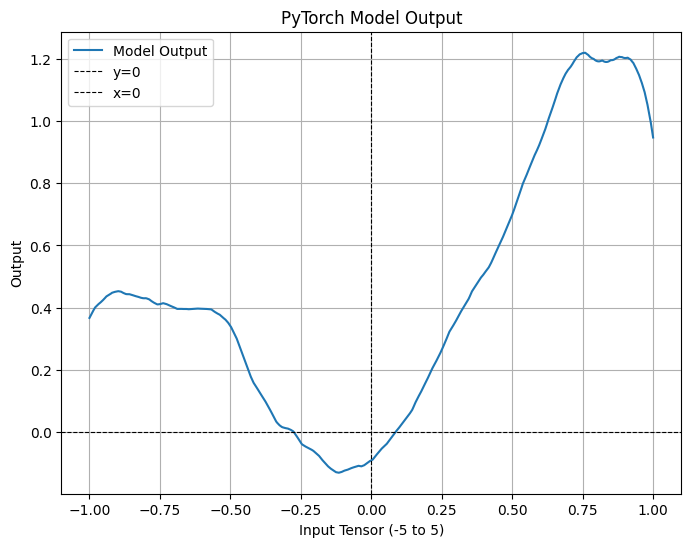

In [505]:
x_input = torch.linspace(-1, 1, 1000).unsqueeze(1)

output = model(x_input).detach().numpy()

plt.figure(figsize=(8, 6))
plt.plot(x_input.numpy(), output, label='Model Output')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='y=0')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--', label='x=0')
plt.title("PyTorch Model Output")
plt.xlabel("Input Tensor (-5 to 5)")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()


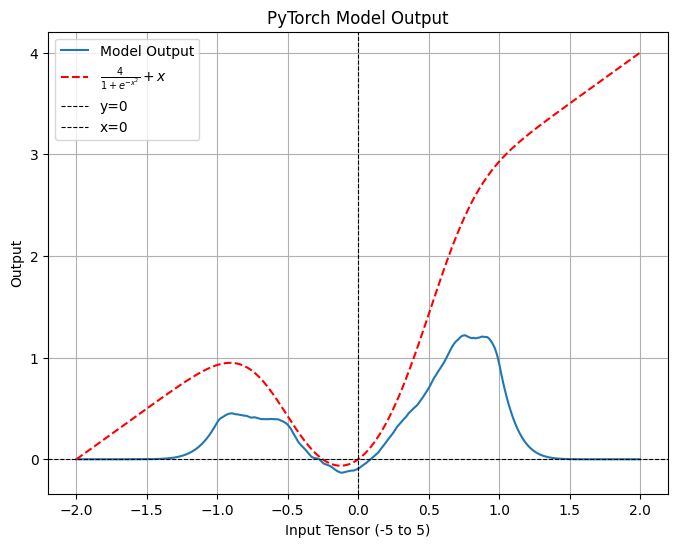

In [506]:
x_input = torch.linspace(-2, 2, 1000).unsqueeze(1)

output = model(x_input).detach().numpy()

additional_line = (4 / (1 + np.exp(-4 * x_input.numpy() ** 2))) + x_input.numpy() - 2

plt.figure(figsize=(8, 6))
plt.plot(x_input.numpy(), output, label='Model Output')
plt.plot(x_input.numpy(), additional_line, label=r'$\frac{4}{1+e^{-x^{2}}}+x$', linestyle='--', color='red')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='y=0')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--', label='x=0')
plt.title("PyTorch Model Output")
plt.xlabel("Input Tensor (-5 to 5)")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

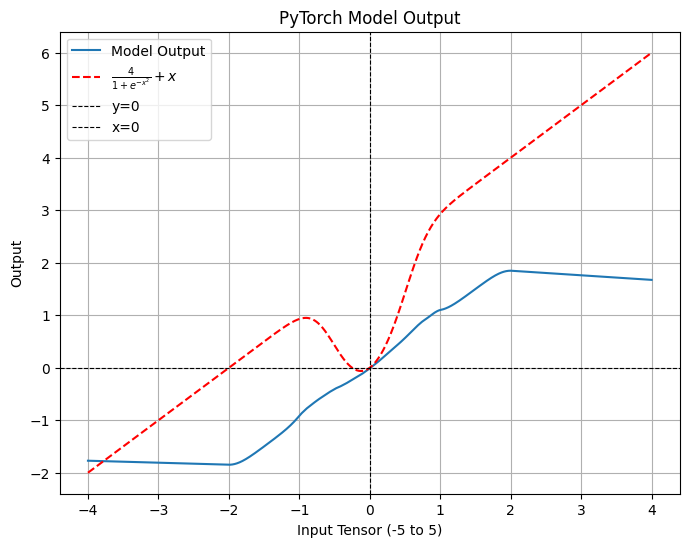

In [490]:
x_input = torch.linspace(-4, 4, 1000).unsqueeze(1)

output = model(x_input).detach().numpy()

additional_line = (4 / (1 + np.exp(-4 * x_input.numpy() ** 2))) + x_input.numpy() - 2

plt.figure(figsize=(8, 6))
plt.plot(x_input.numpy(), output, label='Model Output')
plt.plot(x_input.numpy(), additional_line, label=r'$\frac{4}{1+e^{-x^{2}}}+x$', linestyle='--', color='red')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='y=0')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--', label='x=0')
plt.title("PyTorch Model Output")
plt.xlabel("Input Tensor (-5 to 5)")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

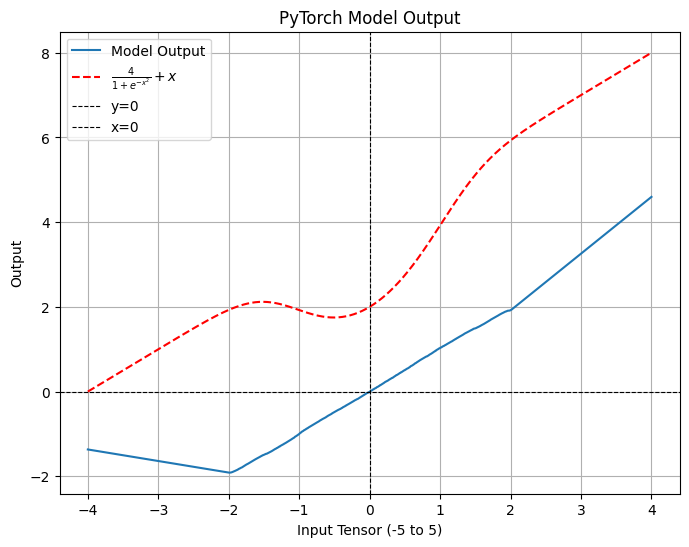

In [461]:
x_input = torch.linspace(-4, 4, 1000).unsqueeze(1)

output = model(x_input).detach().numpy()

additional_line = (4 / (1 + np.exp(-x_input.numpy() ** 2))) + x_input.numpy()

plt.figure(figsize=(8, 6))
plt.plot(x_input.numpy(), output, label='Model Output')
plt.plot(x_input.numpy(), additional_line, label=r'$\frac{4}{1+e^{-x^{2}}}+x$', linestyle='--', color='red')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--', label='y=0')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--', label='x=0')
plt.title("PyTorch Model Output")
plt.xlabel("Input Tensor (-5 to 5)")
plt.ylabel("Output")
plt.legend()
plt.grid()
plt.show()

In [ ]:
num_og_features = 14
num_features = interaction_order
num_classes = 2
num_control_points = 15
num_epochs = 1000
batch_size = 7298

def custom_lr_lambda(step):
    num_step_threshold = 100

    if step < num_step_threshold:
        return step / num_step_threshold
    if step == num_step_threshold:
        print("here")
    return 0.9999 ** (step - num_step_threshold)

start_time = time.time()
model = TabularDenseNet(num_features, num_classes, num_control_points, 4, corr_comb_indices).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01 * 0.02 * 10)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr_lambda)

criterion = CustomLoss(nn.CrossEntropyLoss(), 0.0, 0.0, 0.0001 * 0.0, 0.0001 * 0.0)
evaluate_model(model, custom_train_loader, criterion, optimizer, num_epochs, scheduler, batch_size, num_og_features, early_stopping_patience=100)

models.append(model)
print(f"Execution time: {(time.time() - start_time):.6f} seconds")

In [ ]:
data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

data = data.drop(["id"], axis=1)
data['source'] = 0

grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
data['loan_grade'] = data['loan_grade'].map(grade_mapping)

purpose_mapping = {
    'DEBTCONSOLIDATION': 1,
    'HOMEIMPROVEMENT': 2,
    'MEDICAL': 3,
    'PERSONAL': 4,
    'EDUCATION': 5,
    'VENTURE': 6
}
data['loan_intent'] = data['loan_intent'].map(purpose_mapping)

home_ownership_mapping = {
    'OWN': 1,
    'MORTGAGE': 2,
    'OTHER': 3,
    'RENT': 4
}
data['person_home_ownership'] = data['person_home_ownership'].map(home_ownership_mapping)

print(data.columns)
print(data.isnull().sum())

X = data.drop([], axis=1)

X = pd.get_dummies(X, drop_first=True)

column_to_log = [
    'person_age',
    'person_income',
]

column_to_sqrt = [
    'person_emp_length',
    'loan_percent_income',
]

for col in column_to_log:
    if (X[col] <= 0).any():
        print(f"Column '{col}' contains non-positive values. Adding 1 to avoid log of non-positive numbers.")
        X[col] = np.log(X[col] + 1)
    else:
        X[col] = np.log(X[col])

for col in column_to_sqrt:
    if (X[col] < 0).any():
        print(f"Column '{col}' contains negative values. Setting negative values to NaN before applying sqrt.")
        X[col] = np.sqrt(X[col].clip(lower=0))
    else:
        X[col] = np.sqrt(X[col])

print(X.shape)
print(X.columns)

In [ ]:
print(x_scaled)

In [ ]:
print(X.shape)
X_scaled_test = x_scaler.transform(X)
print(X_scaled_test.shape)
print(X_scaled_test)

In [ ]:
X_scaled_test_tensor = torch.tensor(X_scaled_test).float().to(device)
outputs = models[-1](X_scaled_test_tensor)
print(outputs)

In [ ]:
probabilities = F.softmax(outputs, dim=1)
print(probabilities)

In [ ]:
positive_class_probs = probabilities[:, 1]
print(positive_class_probs)

In [ ]:
import pandas as pd

test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
ids = test_df['id']

positive_class_probs = positive_class_probs.cpu().detach().numpy()

submission_df = pd.DataFrame({
    'id': ids,
    'loan_status': positive_class_probs
})

submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully.")